In [1]:
import sys
sys.path.insert(0,'../..')

In [2]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [131]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
#%matplotlib inline
%matplotlib notebook

import numpy as np
from numba import njit
import multiprocessing as mp

import time

import os
import errno

from scipy.interpolate import RectBivariateSpline as RBS, interp1d as LS, CubicSpline as CS

from ipywidgets import FloatProgress
from IPython.display import display

In [327]:
@njit
def _ABC_flow(t,x,A,B,C):
    return np.array([A*np.sin(x[:,:,:,2])+C*np.cos(x[:,:,:,1]),B*np.sin(x[:,:,:,0])+A*np.cos(x[:,:,:,2]),C*np.sin(x[:,:,:,1])+B*np.cos(x[:,:,:,0])])

@njit
def vel(t,x):
    A = 1.#np.sqrt(3)
    B = 1.#np.sqrt(2)
    C = 1.
    return _ABC_flow(t,x,A,B,C).transpose([1,2,3,0])

@njit
def vx(t,x):
    A = 1.
    B = 1.
    C = 1.
    return A*np.sin(x[2]) + C*np.cos(x[1])

@njit
def vy(t,x):
    A = 1.
    B = 1.
    C = 1.
    return B*np.sin(x[0]) + A*np.cos(x[2])

@njit
def vz(t,x):
    A = 1.
    B = 1.
    C = 1.
    return C*np.sin(x[1]) + B*np.cos(x[0])

In [319]:
xmin,xmax = 0,2*np.pi
ymin,ymax = xmin,xmax
zmin,zmax = xmin,xmax

In [320]:
from numerical_integrators.singlestep import rk2

In [321]:
nx = 10
ny = 10
nz = 10

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

@njit
def makegrid(x,y,z):
    Q = np.zeros((x.shape[0],y.shape[0],z.shape[0],3))
    for j in range(x.shape[0]):
        for k in range(y.shape[0]):
            for l in range(z.shape[0]):
                Q[j,k,l,:] = [x[j],y[k],z[l]]
    return Q

#@njit
def makegridinclauxpart(x,y,z,dx,dy,dz):
    Q = np.zeros((7,x.shape[0],y.shape[0],z.shape[0],3))
    for j in range(x.shape[0]):
        for k in range(y.shape[0]):
            for l in range(z.shape[0]):
                Q[0,j,k,l,:] = [x[j],y[k],z[l]]
                Q[1,j,k,l,:] = [x[j] + dx,y[k],z[l]]
                Q[2,j,k,l,:] = [x[j] - dx,y[k],z[l]]
                Q[3,j,k,l,:] = [x[j],y[k] + dy,z[l]]
                Q[4,j,k,l,:] = [x[j],y[k] - dy,z[l]]
                Q[5,j,k,l,:] = [x[j],y[k],z[l] + dz]
                Q[6,j,k,l,:] = [x[j],y[k],z[l] - dz]
    return Q

_dx = np.minimum(1e-5,dx)
_dy = np.minimum(1e-5,dy)
_dz = np.minimum(1e-5,dz)


In [322]:
def advect_analytical(tstart,tend,grid,vel,h):
    t = np.ones(grid.shape[0])*tstart
    for j in range(np.ceil((tend-tstart)/h).astype(int)):
        for k in range(grid.shape[0]):
            t[k],grid[k],h = rk2(t[k],grid[k],h,vel)
    return grid

In [323]:
g = makegridinclauxpart(x,y,z,_dx,_dy,_dz)
g.shape

(7, 10, 10, 10, 3)

<IPython.core.display.Javascript object>


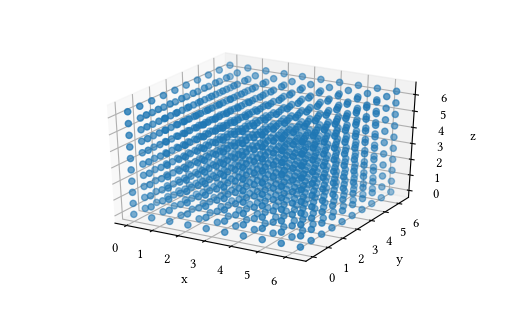

Text(0.5,0,'z')

In [325]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g[0,:,:,:,0],g[0,:,:,:,1],g[0,:,:,:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [328]:
start = time.time()
g2 = advect_analytical(0,1,np.copy(g),vel,0.1)
mins,secs = np.divmod(time.time()-start,60)
print('Advection took {} minutes and {} seconds'.format(mins,secs))

TypingError: Failed at nopython (nopython frontend)
Failed at nopython (nopython frontend)
array(float64, 3d, C) not allowed in a homogenous sequence
[1] During: resolving callee type: Function(<built-in function array>)
[2] During: typing of call at <ipython-input-327-427c3622b9a3> (3)
[3] During: resolving callee type: type(CPUDispatcher(<function _ABC_flow at 0x7f485ab0d0d0>))
[4] During: typing of call at <ipython-input-327-427c3622b9a3> (10)

<IPython.core.display.Javascript object>


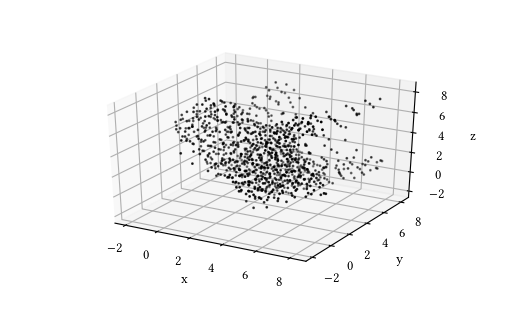

Text(0.5,0,'z')

In [200]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(np.divmod(g2[0,:,:,:,0],2*np.pi)[1],np.divmod(g2[0,:,:,:,1],2*np.pi)[1],np.divmod(g2[0,:,:,:,2],2*np.pi)[1],color='k',s=1)
ax.scatter(g2[0,:,:,:,0],g2[0,:,:,:,1],g2[0,:,:,:,2],c='k',s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [260]:
def periodic_collapse(x):
    return x - np.divmod(x,2*np.pi)[0]*2*np.pi

In [329]:
# Sampling grid
ds = xmax/100

_nx = np.ceil(xmax/ds).astype(int)
_ny = np.ceil(ymax/ds).astype(int)
_nz = np.ceil(zmax/ds).astype(int)

_n = _nx*_ny*_nz

sx = np.linspace(xmin,xmax,_nx)
sy = np.linspace(ymin,ymax,_ny)
sz = np.linspace(zmin,zmax,_nz)

@njit
def velocity_sample_planes(t,sx,sy,sz):
    collection = np.empty((sx.shape[0],sy.shape[0],sz.shape[0],3))
    for k in range(sy.shape[0]):
        for l in range(sz.shape[0]):
            collection[:,k,l,0] = vx(t,np.array([sx[0],sy[k],sz[l]]))
    for j in range(sx.shape[0]):
        for l in range(sz.shape[0]):
            collection[j,:,l,1] = vy(t,np.array([sx[j],sy[0],sz[l]]))
    for j in range(sx.shape[0]):
        for k in range(sy.shape[0]):
            collection[j,k,:,2] = vz(t,np.array([sx[j],sy[k],sz[0]]))
    return collection

In [330]:
%timeit a = velocity_sample_planes(0,sx,sy,sz)

27.6 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [275]:
_ny

99.99999999999999

In [279]:
sz

array([ 0.        ,  0.06346652,  0.12693304,  0.19039955,  0.25386607,
        0.31733259,  0.38079911,  0.44426563,  0.50773215,  0.57119866,
        0.63466518,  0.6981317 ,  0.76159822,  0.82506474,  0.88853126,
        0.95199777,  1.01546429,  1.07893081,  1.14239733,  1.20586385,
        1.26933037,  1.33279688,  1.3962634 ,  1.45972992,  1.52319644,
        1.58666296,  1.65012947,  1.71359599,  1.77706251,  1.84052903,
        1.90399555,  1.96746207,  2.03092858,  2.0943951 ,  2.15786162,
        2.22132814,  2.28479466,  2.34826118,  2.41172769,  2.47519421,
        2.53866073,  2.60212725,  2.66559377,  2.72906028,  2.7925268 ,
        2.85599332,  2.91945984,  2.98292636,  3.04639288,  3.10985939,
        3.17332591,  3.23679243,  3.30025895,  3.36372547,  3.42719199,
        3.4906585 ,  3.55412502,  3.61759154,  3.68105806,  3.74452458,
        3.8079911 ,  3.87145761,  3.93492413,  3.99839065,  4.06185717,
        4.12532369,  4.1887902 ,  4.25225672,  4.31572324,  4.37

In [280]:
g.shape

(7, 10, 10, 10, 3)

In [316]:
g.transpose([0,1,3,2,4])

array([[[[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
          [  0.00000000e+00,   6.98131701e-01,   0.00000000e+00],
          [  0.00000000e+00,   1.39626340e+00,   0.00000000e+00],
          ..., 
          [  0.00000000e+00,   4.88692191e+00,   0.00000000e+00],
          [  0.00000000e+00,   5.58505361e+00,   0.00000000e+00],
          [  0.00000000e+00,   6.28318531e+00,   0.00000000e+00]],

         [[  0.00000000e+00,   0.00000000e+00,   6.98131701e-01],
          [  0.00000000e+00,   6.98131701e-01,   6.98131701e-01],
          [  0.00000000e+00,   1.39626340e+00,   6.98131701e-01],
          ..., 
          [  0.00000000e+00,   4.88692191e+00,   6.98131701e-01],
          [  0.00000000e+00,   5.58505361e+00,   6.98131701e-01],
          [  0.00000000e+00,   6.28318531e+00,   6.98131701e-01]],

         [[  0.00000000e+00,   0.00000000e+00,   1.39626340e+00],
          [  0.00000000e+00,   6.98131701e-01,   1.39626340e+00],
          [  0.00000000e+00,   1.3962634

In [ ]:
g.tr